# Code modified from the original source, found at https://github.com/jvns/neural-nets-are-weird
# Based on the paper by Ian Goodfellow: http://arxiv.org/abs/1412.6572

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
import shutil
import requests
import tempfile
import os
caffe_root = '/root/caffe/'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.mpl_style', 'default')
%matplotlib inline


import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/root/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

In [ ]:
# Set Caffe to CPU mode because who even knows how to set up a GPU (not me)
caffe.set_mode_cpu()

# Load googlenet
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/root/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/root/caffe/models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    # this just means that we're only processing one image at a time instead of like 50
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# Caffe comes with a handy transformer pipeline so that
# we can make our images into the format it needs! Yay!
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [ ]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    if 'png' in url:
        !mv {path} {path}.png
    else:
        !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

def find_labels(label, labels):
    for i in range(len(labels)):
        if labels[i].find(label) >= 0:
            print i, labels[i]
        
def display(data, data2=None, label=None, label2=None):
    if data2 is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,6))
        ax1.imshow(transformer.deprocess('data', data))
        ax1.set_axis_off()
        ax2.imshow(transformer.deprocess('data', data2-data))
        ax2.set_axis_off()
        ax3.imshow(transformer.deprocess('data', data2))
        ax3.set_axis_off()
        
        if label is not None:
            ax1.set_title(label)
            ax2.set_title("    +   distortion    =    ")
            ax3.set_title(label2)
        
    else:
        #just plot one
        plt.imshow(transformer.deprocess('data', data))
        plt.axis('off')

def get_label_name(num):
    options = labels[num].split(',')
    # remove the tag
    options[0] = ' '.join(options[0].split(' ')[1:])
    return ','.join(options[:2])
    
def predict(data, n_preds=6, display_output=True):
    net.blobs['data'].data[...] = data
    if display_output:
        display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        percent = round(probs[pred] * 100, 2)
        # display it compactly if we're displaying more than the top prediction
        pred_formatted = "%03d" % pred
        if n_preds == 1:
            format_string = "label: {cls} ({label})\ncertainty: {certainty}%"
        else:
            format_string = "label: {cls} ({label}), certainty: {certainty}%"
        if display_output:
            print format_string.format(
                cls=pred_formatted, label=get_label_name(pred), certainty=percent)
    return prob


def compute_gradient(image, intended_outcome):
    predict(image, display_output=False)
    # Get an empty set of probabilities
    probs = np.zeros_like(net.blobs['prob'].data)
    # Set the probability for our intended outcome to 1
    probs[0][intended_outcome] = 1
    # Do backpropagation to calculate the gradient for that outcome
    gradient = net.backward(prob=probs)
    return gradient['data'].copy()

def trick(image, desired_output, n_steps=1):
    # maintain a list of outputs at each step
    prediction_steps = []
    for _ in range(n_steps - 1):
        preds = predict(image, display_output=False)
        prediction_steps.append(np.copy(preds))
        grad = compute_gradient(image, desired_output) # paper towel
        delta = np.sign(grad)
        # If there are n steps, we make them size 1/n -- small!
        image = image + delta * 0.9 / n_steps
    return image, prediction_steps

def plot_steps(steps, label_list, **args):
    d = {}
    for label in label_list:
        d[get_label_name(label)] = [s[0][label] for s in steps]
    df = pd.DataFrame(d)
    df.plot(**args)
    plt.xlabel('Step number')
    plt.ylabel('Probability of label')

# Check to see that everything is working.

In [ ]:
cat_data = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))

In [ ]:
predict(cat_data);

In [ ]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
panda_data = get_png_image(panda_url)
predict(panda_data);

label: 207 (golden retriever), certainty: 92.19%
label: 208 (Labrador retriever), certainty: 2.04%
label: 168 (redbone), certainty: 1.08%
label: 176 (Saluki, gazelle hound), certainty: 0.78%
label: 212 (English setter), certainty: 0.34%
label: 213 (Irish setter, red setter), certainty: 0.33%


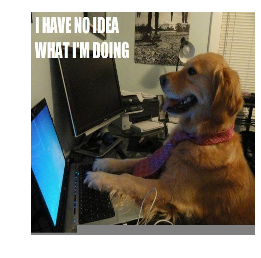

In [48]:
# Sanja:
#image_url = 'https://media.licdn.com/media/p/1/005/082/2f5/2df98c9.jpg'

# Dog:
image_url = 'https://img.buzzfeed.com/buzzfeed-static/static/2014-10/26/6/enhanced/webdr08/enhanced-14836-1414320930-8.jpg'
image_data = get_png_image(image_url)
probs = predict(image_data, n_preds=6)

# Find an interesting label.  Full list is here http://image-net.org/challenges/LSVRC/2014/browse-synsets

In [49]:
find_labels("elephant", labels)

385 n02504013 Indian elephant, Elephas maximus
386 n02504458 African elephant, Loxodonta africana


In [2]:
# Set your desired label and your true label.

desired_label = 385
true_label =  207

# Loop: Add distortion in the direction of the gradient until you get the desired misclassification

In [51]:
image_modified = np.copy(image_data)

# maintain a list of outputs at each prediction
prediction_steps = []
keepGoing = True

while keepGoing:

    grad = compute_gradient(image_modified, desired_label) 
    
    image_modified += 0.14 * np.sign(grad)[0]
    
    
    preds = predict(image_modified, display_output=False)
    keepGoing = preds[0][desired_label] < max(preds[0])
    print "Current prediction: {}".format(labels[np.argmax(preds[0])])
    prediction_steps.append(np.copy(preds))

Current prediction: n02099601 golden retriever
Current prediction: n02099601 golden retriever
Current prediction: n02099601 golden retriever
Current prediction: n02090379 redbone
Current prediction: n02090379 redbone
Current prediction: n02090379 redbone
Current prediction: n02099712 Labrador retriever
Current prediction: n02088466 bloodhound, sleuthhound
Current prediction: n02504013 Indian elephant, Elephas maximus


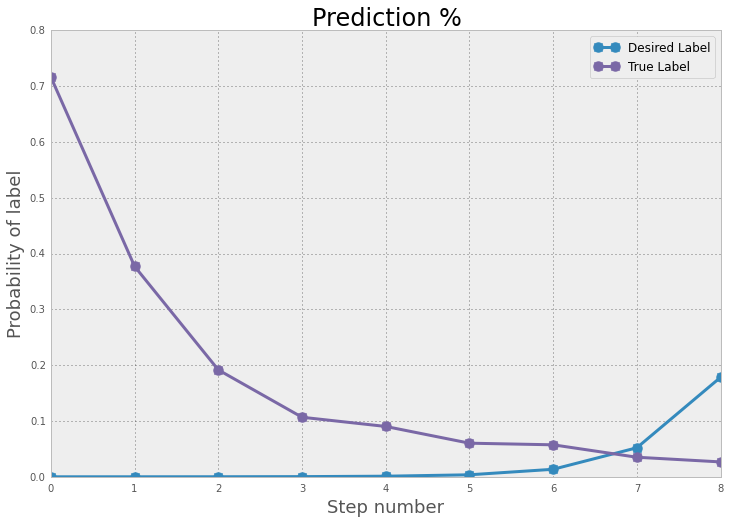

In [52]:
df = pd.DataFrame({
    'Desired Label': [s[0][desired_label] for s in prediction_steps],
    'True Label': [s[0][true_label] for s in prediction_steps]
    })

df.plot(figsize=(12,8), marker='.', ms=20, lw=3)
plt.xlabel('Step number', size=18)
plt.ylabel('Probability of label', size=18)
plt.title('Prediction %', size=24)
plt.show()

label: 385 (Indian elephant, Elephas maximus), certainty: 17.83%
label: 163 (bloodhound, sleuthhound), certainty: 6.79%
label: 150 (sea lion), certainty: 5.44%
label: 208 (Labrador retriever), certainty: 4.8%
label: 159 (Rhodesian ridgeback), certainty: 4.71%
label: 209 (Chesapeake Bay retriever), certainty: 3.62%


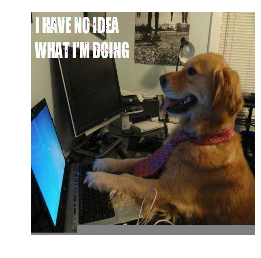

In [53]:
predict(image_modified);

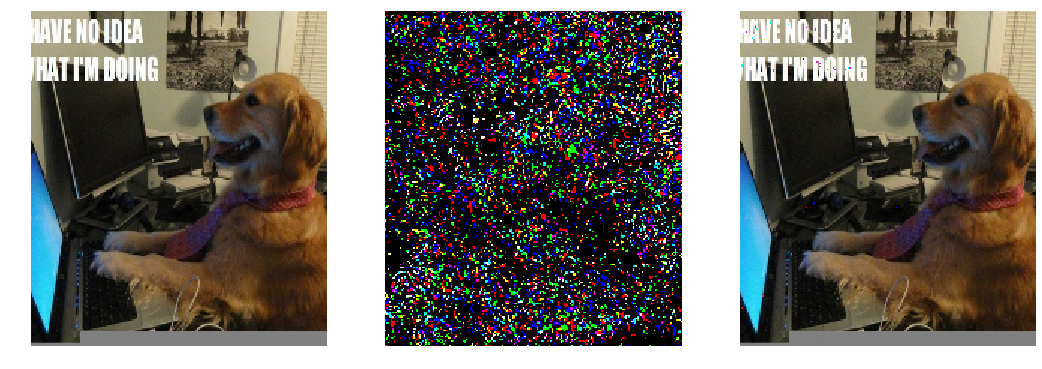

In [54]:
display(image_data, image_modified)

# As per the method of Goodfellow, just take one tiny step in the opposite direction of the true class label and see how much your prediction changes

### Note: This works best when the network isn't very confident about the original image

In [ ]:
image_url = 'https://media.licdn.com/media/p/1/005/082/2f5/2df98c9.jpg'
#image_url = 'http://animaliaz-life.com/data_images/salmon/salmon1.jpg'
image_data = get_png_image(image_url)
probs = predict(image_data, n_preds=6)

In [ ]:
grad = compute_gradient(image_data, 903)

In [ ]:
predict(image_data - 0.07*np.sign(grad));